# Environment settings

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import tensorflow as tf
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plot
import cv2 as cv
import pandas as pd
from protein_utils import TrainingHelper
from sklearn.metrics import f1_score
import tensorflow.keras.backend as K
import random
import os
from IPython.display import Image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
TRAIN_PATH = 'data/train/'
TEST_PATH = 'data/test/'
HPA_PATH = 'data/HPA/'
NUM_OF_CLASSES = 28
mean_image_g, std_image_g = 0.054918356, 0.11642134
mean_image_r, std_image_r = 0.08131433, 0.15016304
mean_image_b, std_image_b = 0.05485828, 0.15576825
OPTIMIZERS = {
    "Adam" : tf.train.AdamOptimizer,
    "SGD" : tf.train.GradientDescentOptimizer,
    "RMS" : tf.train.RMSPropOptimizer
}

In [5]:
# Set tf basic settings
print(tf.__version__)
tf.logging.set_verbosity(tf.logging.INFO)
tf.enable_eager_execution()

1.10.0


# Dataset creation

### Donwload HPA additional records

In [75]:
import requests

colors = ['red','green','blue']
DIR = "data/HPA/"
v18_url = 'http://v18.proteinatlas.org/images/'
imgList = pd.read_csv("data/HPA/HPAv18RBGY_wodpl.csv")

print(len(imgList))

for i in imgList['Id'][66855:]:
    img = i.split('_')
    for color in colors:
        img_path = img[0] + '/' + "_".join(img[1:]) + "_" + color + ".png"
        img_name = i + "_" + color + ".png"
        img_url = v18_url + img_path
        r = requests.get(img_url, allow_redirects=True)
        open(DIR + img_name, 'wb').write(r.content)


74606
<Response [404]>
<Response [404]>
<Response [404]>


In [8]:
print("done")

done


### Utility functions for creating tfrecords to be used in datasets

In [113]:
bad_files = []
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
def load_image_specific_filter(file):
    img = cv.imread(file, -1)
    img = img.astype(np.float32)
    #if (len(img.shape) != 2):
        #print("W: bad shape:{}, file:{}".format(img.shape, file))
    return img

### Create training set tfrecords

In [119]:
# Read training data from train.csv file
hpa_labels = pd.read_csv(HPA_PATH + "HPAv18RBGY_wodpl.csv")

num_of_examples = hpa_labels.count()['Id']

for i in range(37546, int(num_of_examples)):
    if (i % 1000 == 0):
        print("Reached image {} out of {}".format(i, num_of_examples))
        
    # Open writer for specific example
    train_filename = 'data/tfrec/HPA/' + hpa_labels['Id'][i] + '.tfrec'
    writer = tf.python_io.TFRecordWriter(train_filename)
    
    file_name = (HPA_PATH + hpa_labels['Id'][i] + '_green.jpg')
    img_g = load_image_specific_filter(file_name)
    if len(img_g.shape) == 3:
        img_g = img_g[:,:,1]
    img_g = cv.resize(img_g, (512,512))
    img_g = np.reshape(img_g, (512,512,1))
    file_name = (HPA_PATH + hpa_labels['Id'][i] + '_red.jpg')
    img_r = load_image_specific_filter(file_name)
    if len(img_r.shape) == 3:
        img_r = img_r[:,:,2]
    img_r = cv.resize(img_r, (512,512))
    img_r = np.reshape(img_r, (512,512,1))
    file_name = (HPA_PATH + hpa_labels['Id'][i] + '_blue.jpg')
    img_b = load_image_specific_filter(file_name)
    if len(img_b.shape) == 3:
        img_b = img_b[:,:,0]
    img_b = cv.resize(img_b, (512,512))
    img_b = np.reshape(img_b, (512,512,1))

    img = np.concatenate((img_r, img_g, img_b),axis=2)
    

    labels = np.zeros(shape=(NUM_OF_CLASSES), dtype=int)
    train_label = [int(s) for s in hpa_labels['Target'][i].split(' ')]
    labels[train_label] = 1
    
    # Create a feature to insert
    feature = {'train/label': _int64_feature(labels),
               'train/image': _bytes_feature(tf.compat.as_bytes(img.tostring()))}
    
    # Create an example protocol buffer
    example = tf.train.Example(features=tf.train.Features(feature=feature))

    # Serialize to string and write on the file
    writer.write(example.SerializeToString())
    
    # Close writer
    writer.close() 


Reached image 38000 out of 74606
Reached image 39000 out of 74606
Reached image 40000 out of 74606
Reached image 41000 out of 74606
Reached image 42000 out of 74606
Reached image 43000 out of 74606
Reached image 44000 out of 74606
Reached image 45000 out of 74606
Reached image 46000 out of 74606
Reached image 47000 out of 74606
Reached image 48000 out of 74606
Reached image 50000 out of 74606
Reached image 51000 out of 74606
Reached image 52000 out of 74606
Reached image 53000 out of 74606
Reached image 54000 out of 74606
Reached image 55000 out of 74606
Reached image 56000 out of 74606
Reached image 57000 out of 74606
Reached image 58000 out of 74606
Reached image 59000 out of 74606
Reached image 60000 out of 74606
Reached image 61000 out of 74606
Reached image 62000 out of 74606
Reached image 63000 out of 74606
Reached image 64000 out of 74606
Reached image 65000 out of 74606
Reached image 66000 out of 74606
Reached image 67000 out of 74606


In [122]:
print(i)

74605


In [111]:
# Read training data from train.csv file
train_labels = pd.read_csv(TRAIN_PATH + "train.csv")

# Split training examples intot training and validation set
num_of_examples = train_labels.count()['Id']
num_train_set = int(num_of_examples * 0.85)
num_validation_set = num_of_examples - num_train_set

for i in range(0, int(num_train_set)):
    if (i % 1000 == 0):
        print("Reached image {} out of {}".format(i, num_train_set))
        
    # Open writer for specific example
    train_filename = 'data/tfrec/train/' + train_labels['Id'][i] + '.tfrec'
    writer = tf.python_io.TFRecordWriter(train_filename)
    
    file_name = (TRAIN_PATH + train_labels['Id'][i] + '_green.png')
    img_g = load_image_specific_filter(file_name)
    img_g = np.reshape(img_g, (512,512,1))
    file_name = (TRAIN_PATH + train_labels['Id'][i] + '_red.png')
    img_r = load_image_specific_filter(file_name)
    img_r = np.reshape(img_r, (512,512,1))
    file_name = (TRAIN_PATH + train_labels['Id'][i] + '_blue.png')
    img_b = load_image_specific_filter(file_name)
    img_b = np.reshape(img_b, (512,512,1))
    img = np.concatenate((img_r, img_g, img_b),axis=2)
    
    labels = np.zeros(shape=(NUM_OF_CLASSES), dtype=int)
    train_label = [int(s) for s in train_labels['Target'][i].split(' ')]
    labels[train_label] = 1
    
    # Create a feature to insert
    feature = {'train/label': _int64_feature(labels),
               'train/image': _bytes_feature(tf.compat.as_bytes(img.tostring()))}
    
    # Create an example protocol buffer
    example = tf.train.Example(features=tf.train.Features(feature=feature))

    # Serialize to string and write on the file
    writer.write(example.SerializeToString())
    
    # Close writer
    writer.close() 

Reached image 0 out of 26411


### Create validation set tfrecords

In [51]:
num_validation_set = num_of_examples - num_train_set

for i in range(int(num_train_set), num_of_examples):                        
    if (i % 1000 == 0):
        print("Reached image {} out of {}".format(i, num_of_examples))
        
    # Open writer for specific example
    train_filename = 'data/tfrec/validation/' + train_labels['Id'][i] + '.tfrec'
    writer = tf.python_io.TFRecordWriter(train_filename)
    
    file_name = (TRAIN_PATH + train_labels['Id'][i] + '_green.png')
    img_g = load_image_specific_filter(file_name)
    img_g = np.reshape(img_g, (512,512,1))
    file_name = (TRAIN_PATH + train_labels['Id'][i] + '_red.png')
    img_r = load_image_specific_filter(file_name)
    img_r = np.reshape(img_r, (512,512,1))
    file_name = (TRAIN_PATH + train_labels['Id'][i] + '_blue.png')
    img_b = load_image_specific_filter(file_name)
    img_b = np.reshape(img_b, (512,512,1))
    img = np.concatenate((img_r, img_g, img_b),axis=2)

    labels = np.zeros(shape=(NUM_OF_CLASSES), dtype=int)
    train_label = [int(s) for s in train_labels['Target'][i].split(' ')]
    labels[train_label] = 1
    
    # Create a feature to insert
    feature = {'validation/label': _int64_feature(labels),
               'validation/image': _bytes_feature(tf.compat.as_bytes(img.tostring()))}
    
    # Create an example protocol buffer
    example = tf.train.Example(features=tf.train.Features(feature=feature))

    # Serialize to string and write on the file
    writer.write(example.SerializeToString())
    
    # Close writer
    writer.close() 

Reached image 27000 out of 31072
Reached image 28000 out of 31072
Reached image 29000 out of 31072
Reached image 30000 out of 31072
Reached image 31000 out of 31072


### Create test set tfrecords

In [53]:
test_labels = pd.read_csv("sample_submission.csv")
num_of_test_images = test_labels.count()['Id']

for i in range(0, num_of_test_images):
    if (i % 1000 == 0):
        print("Reached image {} out of {}".format(i, num_of_test_images))
        
    # Open writer for specific example
    test_filename = 'data/tfrec/test/' + test_labels['Id'][i] + '.tfrec'
    writer = tf.python_io.TFRecordWriter(test_filename)
    
    file_name = (TEST_PATH + test_labels['Id'][i] + '_green.png')
    img_g = load_image_specific_filter(file_name)
    img_g = np.reshape(img_g, (512,512,1))
    file_name = (TEST_PATH + test_labels['Id'][i] + '_red.png')
    img_r = load_image_specific_filter(file_name)
    img_r = np.reshape(img_r, (512,512,1))
    file_name = (TEST_PATH + test_labels['Id'][i] + '_blue.png')
    img_b = load_image_specific_filter(file_name)
    img_b = np.reshape(img_b, (512,512,1))
    img = np.concatenate((img_r, img_g, img_b),axis=2)
    
    # Create a feature to insert
    feature = {'test/image': _bytes_feature(tf.compat.as_bytes(img.tostring()))}
    
    # Create an example protocol buffer
    example = tf.train.Example(features=tf.train.Features(feature=feature))

    # Serialize to string and write on the file
    writer.write(example.SerializeToString())
    
    # Close writer
    writer.close() 

Reached image 0 out of 11702
Reached image 1000 out of 11702
Reached image 2000 out of 11702
Reached image 3000 out of 11702
Reached image 4000 out of 11702
Reached image 5000 out of 11702
Reached image 6000 out of 11702
Reached image 7000 out of 11702
Reached image 8000 out of 11702
Reached image 9000 out of 11702
Reached image 10000 out of 11702
Reached image 11000 out of 11702


In [61]:
bad_files

[]

### Feature extraction functions

In [5]:
def extract_fn_train(data_record):
    features = {
        # Extract features using the keys set during creation
        'train/label': tf.FixedLenFeature((28), tf.int64),
        'train/image': tf.FixedLenFeature([], tf.string)
    }    
    
    sample = tf.parse_single_example(data_record, features)
    sample['train/image'] = tf.decode_raw(sample['train/image'], tf.float32)
    sample['train/image'] = tf.reshape(sample['train/image'], (512,512,3))
    sample['train/image'] = sample['train/image']/255
    
    return sample

def extract_fn_validation(data_record):
    features = {
        # Extract features using the keys set during creation
        'validation/label': tf.FixedLenFeature((28), tf.int64),
        'validation/image': tf.FixedLenFeature([], tf.string)
    }    
    
    sample = tf.parse_single_example(data_record, features)
    sample['validation/image'] = tf.decode_raw(sample['validation/image'], tf.float32)
    sample['validation/image'] = tf.reshape(sample['validation/image'], (512,512,3))
    sample['validation/image'] = sample['validation/image']/255

    return sample

def extract_fn_test(data_record):
    features = {
        'test/image': tf.FixedLenFeature([], tf.string)
    }    
    
    sample = tf.parse_single_example(data_record, features)
    sample['test/image'] = tf.decode_raw(sample['test/image'], tf.float32)
    sample['test/image'] = tf.reshape(sample['test/image'], (512,512,3))
    sample['test/image'] = sample['test/image']/255
    
    return sample

# Protein classifier model

In [6]:
class ProteinClassifier(tf.keras.Model):
    def __init__(self, optimizer="Adam", lr=1e-3):
        super().__init__()
        
        self.threshold = 0.5
        
        # Block1
        self.block1_conv1 = tf.keras.layers.Conv2D(filters=24,
                                                kernel_size=[3, 3],
                                                strides=(1, 1),
                                                padding='same',
                                                use_bias=True,
                                                activation=tf.nn.relu,
                                                kernel_regularizer=tf.keras.regularizers.l2(0.05),
                                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                               )
        
        self.block1_pool = tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                               strides=(2, 2),
                                               padding='valid'
                                              )
        
        # Block2
        self.block2_conv1 = tf.keras.layers.Conv2D(filters=24,
                                                kernel_size=[3, 3],
                                                strides=(1, 1),
                                                padding='same',
                                                use_bias=True,
                                                activation=tf.nn.relu,
                                                kernel_regularizer=tf.keras.regularizers.l2(0.05),
                                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                               )
              
        
        self.block2_pool = tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                               strides=(2, 2),
                                               padding='valid'
                                              )
        
        # Block3
        self.block3_conv1 = tf.keras.layers.Conv2D(filters=32,
                                                kernel_size=[3, 3],
                                                strides=(1, 1),
                                                padding='same',
                                                use_bias=True,
                                                activation=tf.nn.relu,
                                                kernel_regularizer=tf.keras.regularizers.l2(0.05),
                                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                               )
        
        self.block3_conv2 = tf.keras.layers.Conv2D(filters=32,
                                                kernel_size=[3, 3],
                                                strides=(1, 1),
                                                padding='same',
                                                use_bias=True,
                                                activation=tf.nn.relu,
                                                kernel_regularizer=tf.keras.regularizers.l2(0.05),
                                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                               )       
        
        self.block3_pool = tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                               strides=(2, 2),
                                               padding='valid'
                                              )
        
        # Block4
        self.block4_conv1 = tf.keras.layers.Conv2D(filters=32,
                                                kernel_size=[3, 3],
                                                strides=(1, 1),
                                                padding='same',
                                                use_bias=True,
                                                activation=tf.nn.relu,
                                                kernel_regularizer=tf.keras.regularizers.l2(0.05),
                                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                               )
        
        
        self.block4_conv2 = tf.keras.layers.Conv2D(filters=32,
                                                kernel_size=[3, 3],
                                                strides=(1, 1),
                                                padding='same',
                                                use_bias=True,
                                                activation=tf.nn.relu,
                                                kernel_regularizer=tf.keras.regularizers.l2(0.05),
                                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                               )     
        
        self.block4_pool = tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                               strides=(2, 2),
                                               padding='valid'
                                              )
        
        # Block5
        self.block5_conv1 = tf.keras.layers.Conv2D(filters=32,
                                                kernel_size=[3, 3],
                                                strides=(1, 1),
                                                padding='same',
                                                use_bias=True,
                                                activation=tf.nn.relu,
                                                kernel_regularizer=tf.keras.regularizers.l2(0.05),
                                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                               )
        
        self.block5_conv2 = tf.keras.layers.Conv2D(filters=32,
                                                kernel_size=[3, 3],
                                                strides=(1, 1),
                                                padding='same',
                                                use_bias=True,
                                                activation=tf.nn.relu,
                                                kernel_regularizer=tf.keras.regularizers.l2(0.05),
                                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                               )
        
        
        self.block5_pool = tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                               strides=(2, 2),
                                               padding='valid'
                                              )
        
        
        
        # Dense layers
        self.fc1 = tf.keras.layers.Dense(1024, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(0.05))
        self.fc2 = tf.keras.layers.Dense(512, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(0.05))
        
        # Dropout layers
        self.dropout_conv = tf.keras.layers.Dropout(rate=0.3)
        self.dropout = tf.keras.layers.Dropout(rate=0.3)
    
        # Dense layer for classes
        self.fc3 = tf.keras.layers.Dense(NUM_OF_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(0.05))
                                         
        # Optimizers
        self.cross_entropy_optimizer = OPTIMIZERS[optimizer](learning_rate=lr)
        
    def preprocess_inputs(self, inputs):
        processes_inputs = np.zeros_like(inputs)
        processes_inputs[:,:,:,0] = (inputs[:,:,:,0] - mean_image_r)/std_image_r
        processes_inputs[:,:,:,1] = (inputs[:,:,:,1] - mean_image_g)/std_image_g
        processes_inputs[:,:,:,2] = (inputs[:,:,:,2] - mean_image_b)/std_image_b
        
        return processes_inputs
            
            
    def call(self, inputs, training=True, dropout=False, augment=False, blur=False, **kwargs):
                
        if (augment):
            for i in range(inputs.shape[0]):
                flip_desicion = random.randint(0, 3)
                if (flip_desicion == 1):
                    inputs[i] = cv.flip(inputs[i], 0)
                if (flip_desicion == 2):
                    inputs[i] = cv.flip(inputs[i], 1)
                if (flip_desicion == 3):
                    inputs[i] = cv.flip(inputs[i], -1)
                if random.choice([True, False]):
                    shift_amount = random.randint(0,500)
                    inputs[i] = np.concatenate((inputs[i][shift_amount:,:,:], inputs[i][:shift_amount,:,:]), axis=0)
                if random.choice([True, False]):
                    shift_amount = random.randint(0,500)
                    inputs[i] = np.concatenate((inputs[i][:,shift_amount:,:], inputs[i][:,:shift_amount,:]), axis=1)
                if random.choice([False, False]):
                    mu, sigma = 0.5, 0.05
                    s = np.random.normal(mu, sigma, (50,50,3))
                    s = s.astype(np.float32)
                    rand_ver = random.randint(0,461)
                    rand_hor = random.randint(0,461)
                    inputs[i][rand_ver:rand_ver+50, rand_hor:rand_hor+50,:] = s
        
        # Input Layer
        processed_inputs = self.preprocess_inputs(inputs)
        input_layer = tf.reshape(processed_inputs, [-1, 512, 512, 3])            
        
        # Block1
        x_1 = self.block1_conv1(input_layer)
        x_1 = self.block1_pool(x_1)
        
        # Block2
        x_2 = self.block2_conv1(x_1)
        x_2 = self.block2_pool(x_2)   
        
        # Block3
        x_3 = self.block3_conv1(x_2)
        x_3 = self.block3_conv2(x_3)
        x_3 = self.block3_pool(x_3)
        
        # Block4
        x_4 = self.block4_conv1(x_3)
        x_4 = self.block4_conv2(x_4)
        x_4 = self.block4_pool(x_4)
        
        # Block5
        x_5 = self.block5_conv1(x_4)
        x_5 = self.block5_conv2(x_5)
        x_5 = self.block5_pool(x_5)  
        x_5 = tf.reshape(x_5, [x_5.shape[0], -1])
        
        x_fc = self.fc1(x_5)
        
        if (dropout):
            x_fc = self.dropout(x_fc)
            
        x_fc = self.fc2(x_fc)
        
        if (dropout):
            x_fc = self.dropout(x_fc)
        
            
        logits = self.fc3(x_fc)
        
        return logits 
    
    def cross_entropy_loss(self, labels, logits):        
        labels_cast = tf.cast(labels, tf.float32)
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels_cast, logits=logits)
        cross_entropy_loss = tf.reduce_mean(loss)
        
        return cross_entropy_loss
    
    def f1_loss(self, labels, logits):        
        preds = self.get_normalized_logits(logits)
        f1_scores = self.calc_f1_scores(labels, preds)
        f1_loss = 1 - f1_scores
        
        return f1_loss    
    
    def optimize(self, inputs, labels, training=True, dropout=False, augment=False, blur=False, loss_type='cross_entropy'):
        with tf.GradientTape(persistent=True) as tape:
            logits = self.get_logits(inputs, training=training, dropout=dropout, augment=augment, blur=blur)
        
            if loss_type=='cross_entropy':
                loss = self.cross_entropy_loss(labels, logits)

            else:
                loss = self.f1_loss(labels, logits)
        
        if training:
            gradients = tape.gradient(loss, self.variables)
            self.cross_entropy_optimizer.apply_gradients(zip(gradients, self.variables))

        del(tape)
        return loss
    
    def test(self, inputs, labels):

        predictions = self.predict_protein(inputs)
        
        f1_scores = self.calc_f1_scores(labels, predictions)
        
        return f1_scores

    def calc_f1_scores(self, labels, predictions):
        
        labels_cast = tf.cast(labels, tf.float32)
        
        relevant_labels = np.where(K.sum(labels_cast, axis=0))
        #relevant_predictions = np.where(K.sum(predictions, axis=0))
        #relevant_classes = list(set(relevant_labels[0].tolist() + relevant_predictions[0].tolist()))
        tp = K.sum(K.cast(labels_cast*predictions, 'float'), axis=0)
        tn = K.sum(K.cast((1-labels_cast)*(1-predictions), 'float'), axis=0)
        fp = K.sum(K.cast((1-labels_cast)*predictions, 'float'), axis=0)
        fn = K.sum(K.cast(labels_cast*(1-predictions), 'float'), axis=0)

        p = tp / (tp + fp + K.epsilon())
        r = tp / (tp + fn + K.epsilon())

        f1 = 2*p*r / (p+r+K.epsilon())

        f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
        f1 = tf.gather(f1, relevant_labels)

        f1 = tf.reduce_mean(f1)

        return f1

    def get_best_thresh(self, predictions, labels, save_threshold=False, step_size=0.005):
        thresholds = np.arange(0, 1, step_size)
        best_f1_score = 0
        best_thresh = 0
        for th in thresholds:
            under = np.where(np.array(predictions) < th)
            over = np.where(np.array(predictions) >= th)
            preds = np.array(predictions)
            preds[under] = 0
            preds[over] = 1
            prediction = tf.convert_to_tensor(preds, dtype=tf.float32)
            curr_f1_score = self.calc_f1_scores(labels, prediction)
            if (curr_f1_score > best_f1_score):
                best_f1_score = curr_f1_score
                best_thresh = th
                
        if (save_threshold):
            self.threshold = best_thresh
        
        
        return best_thresh, best_f1_score
        
        
    def get_logits(self, inputs, training=False, dropout=False, augment=False, blur=False):
        logits = self(inputs, training=training, dropout=dropout, augment=augment, blur=blur)
        return logits

    def get_normalized_logits(self, logits):
        return tf.nn.sigmoid(logits)
    
    def predict_protein(self, inputs, debug_print=False):
        returned_prediction = np.zeros((int(inputs.shape[0]), 28))
        logits = self.get_logits(inputs)
        predictions = self.get_normalized_logits(logits).numpy()
        
        for i in range(int(inputs.shape[0])):
        
            max_prediction = np.argmax(predictions[i])

            if predictions[i][max_prediction] < self.threshold:
                returned_prediction[i][max_prediction] = 1
            else:
                over = np.where(predictions[i] >= self.threshold)[0]
                returned_prediction[i][over] = 1
            

        if (debug_print):
            print("Class predictions: {}".format(np.where(returned_prediction==1)[0]))
            print("Probs: {}".format(predictions))

        return returned_prediction
        

### Create 4 datasets, train, validation, test and mini dataset

In [7]:
list_of_test_tfrec = []
test_labels = pd.read_csv("sample_submission.csv")
num_of_test_images = test_labels.count()['Id']

for i in range(0, num_of_test_images):
    test_filename = 'data/tfrec/test/' + test_labels['Id'][i] + '.tfrec'
    list_of_test_tfrec.append(test_filename)

In [8]:
list_of_rare = [8, 9, 10, 15, 16, 17, 27]
rare_examples = []
train_labels = pd.read_csv(TRAIN_PATH + "train.csv")
# Split training examples intot training and validation set
num_of_examples = train_labels.count()['Id']
num_train_set = int(num_of_examples * 0.85)
num_validation_set = num_of_examples - num_train_set

for i in range(0, int(num_train_set)): 
    train_filename = 'data/tfrec/train/' + train_labels['Id'][i] + '.tfrec'
    labels = np.zeros(shape=(NUM_OF_CLASSES), dtype=int)
    train_label = [int(s) for s in train_labels['Target'][i].split(' ')]
    for label in train_label:
        if label in list_of_rare:
            rare_examples.append(train_filename)
list_of_train_tfrec = os.listdir('data/tfrec/train')
list_of_train_tfrec = ['data/tfrec/train/' + file_name for file_name in list_of_train_tfrec]
for i in range(10):
    list_of_train_tfrec = list_of_train_tfrec + rare_examples
random.shuffle(list_of_train_tfrec)

In [9]:
num_epochs_test = 1
batch_size_test = 16
submission_dataset = tf.data.TFRecordDataset(list_of_test_tfrec)
submission_dataset = submission_dataset.map(extract_fn_test)
submission_dataset = submission_dataset.batch(batch_size_test)

list_of_validation_tfrec = os.listdir('data/tfrec/validation')
list_of_validation_tfrec = ['data/tfrec/validation/' + file_name for file_name in list_of_validation_tfrec]
num_epochs_val = 1
batch_size_val = 16
val_dataset = tf.data.TFRecordDataset(list_of_validation_tfrec)
val_dataset = val_dataset.map(extract_fn_validation)
val_dataset = val_dataset.batch(batch_size_val)


num_epochs = 20
batch_size = 16
buffer_size = 300
train_dataset = tf.data.TFRecordDataset(list_of_train_tfrec)
train_dataset = train_dataset.map(extract_fn_train)
train_dataset = train_dataset.apply(tf.contrib.data.shuffle_and_repeat(buffer_size, num_epochs))
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.apply(tf.contrib.data.prefetch_to_device("/device:GPU:0"))

num_epochs_mini = 30
batch_size_mini = 16
buffer_size_mini = 80
mini_dataset = tf.data.TFRecordDataset(list_of_train_tfrec[0:320])
mini_dataset = mini_dataset.map(extract_fn_train)
mini_dataset = mini_dataset.apply(tf.contrib.data.shuffle_and_repeat(buffer_size_mini, num_epochs_mini))
mini_dataset = mini_dataset.batch(batch_size_mini)
mini_dataset = mini_dataset.apply(tf.contrib.data.prefetch_to_device("/device:GPU:0"))

### Train model to overfit on mini dataset

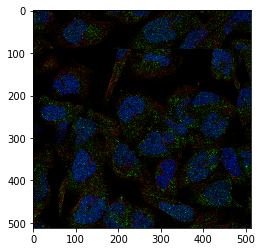

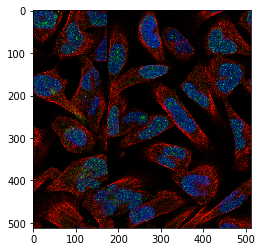

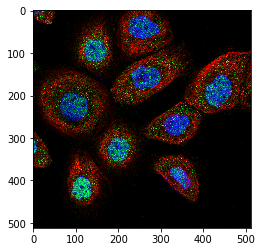

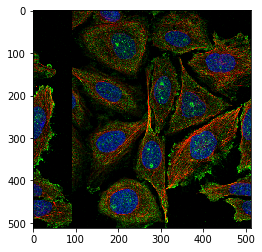

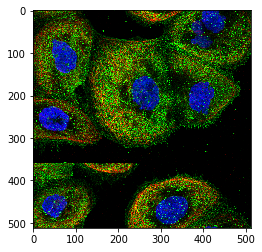

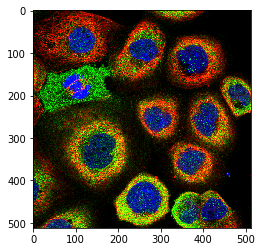

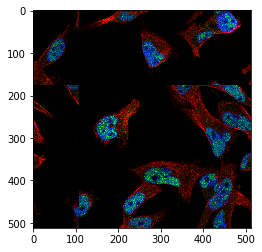

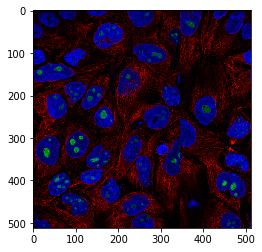

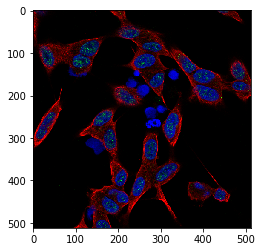

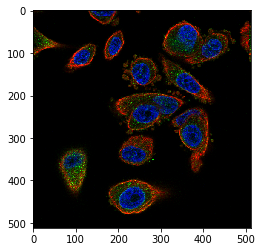

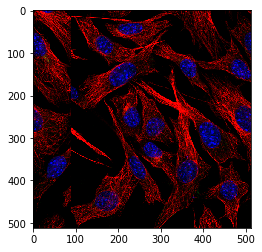

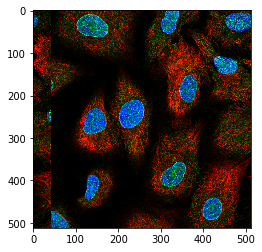

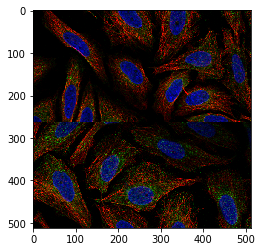

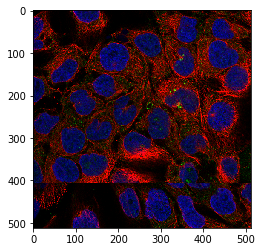

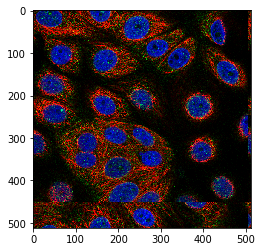

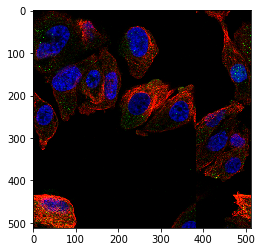

[20.11|22:18:07] Step 0: training loss: 0.691521
[20.11|22:18:07] Step 0: training F1 score: 0.128731


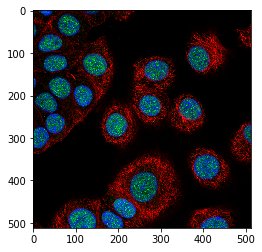

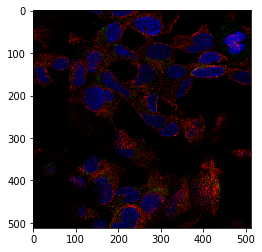

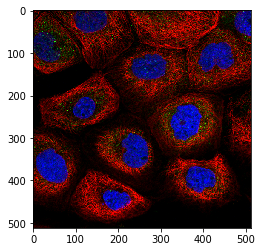

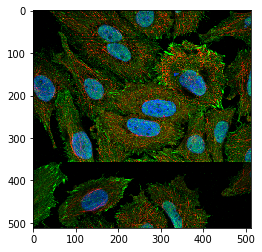

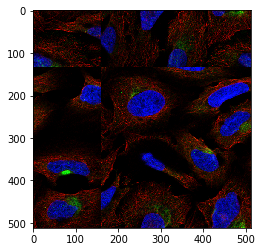

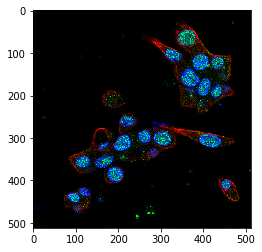

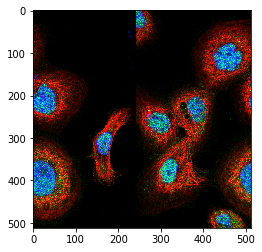

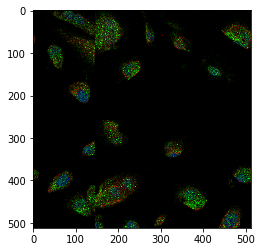

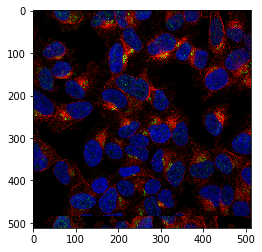

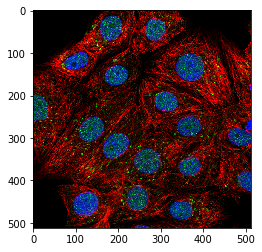

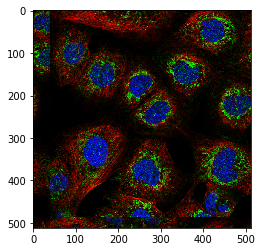

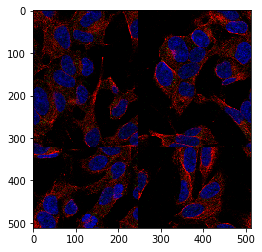

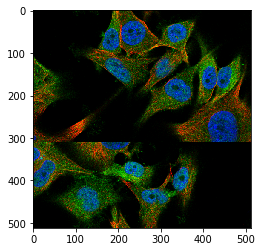

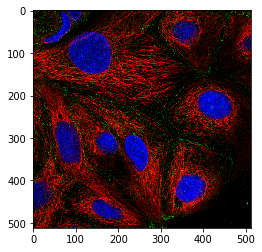

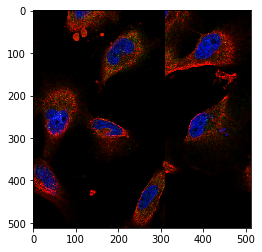

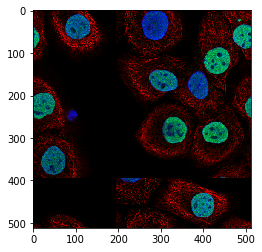

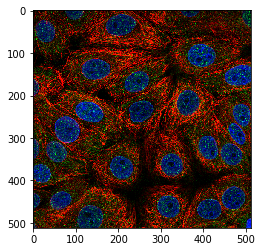

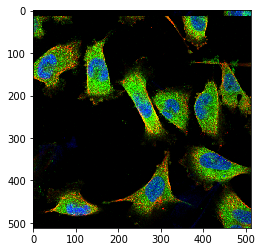

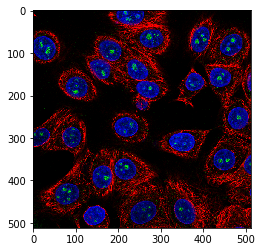

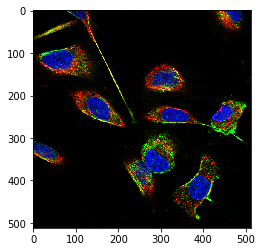

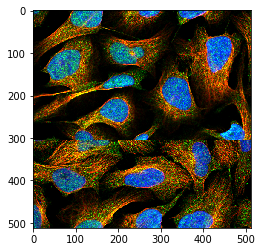

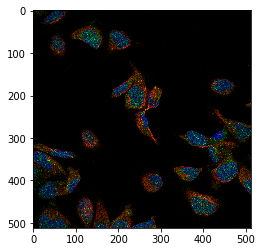

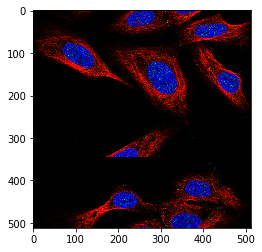

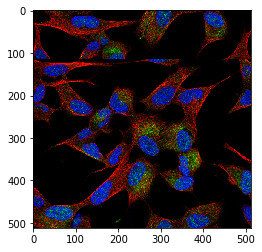

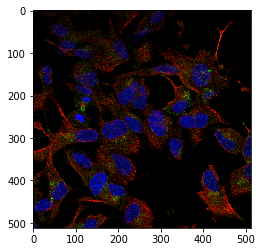

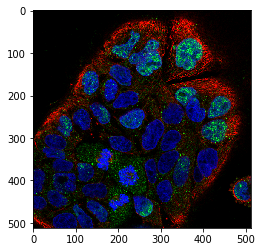

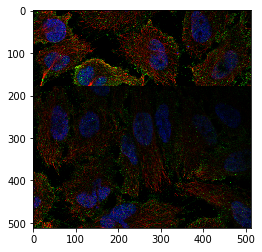

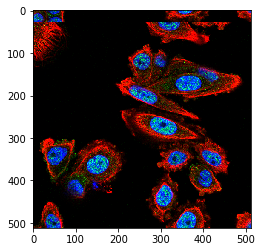

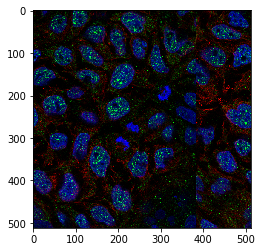

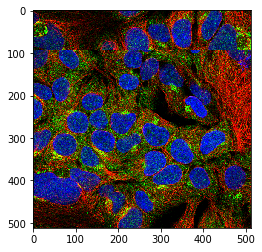

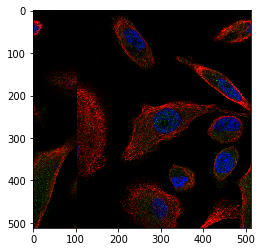

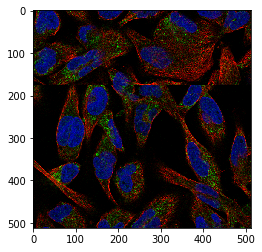

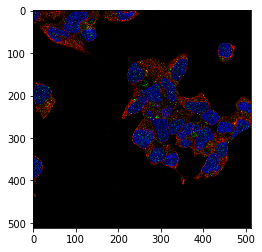

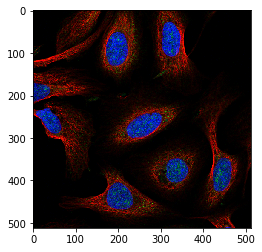

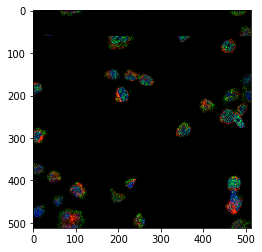

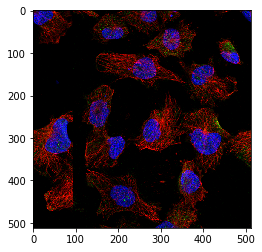

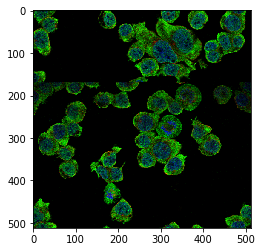

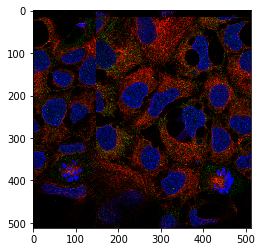

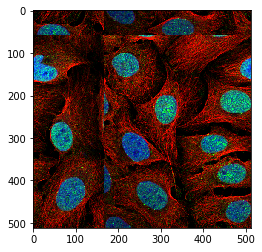

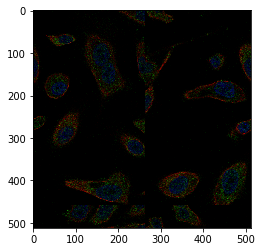

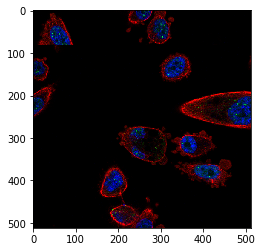

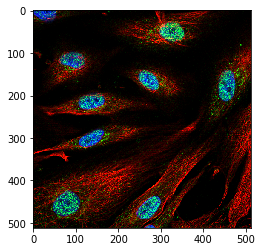

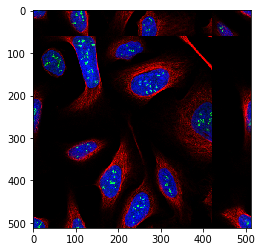

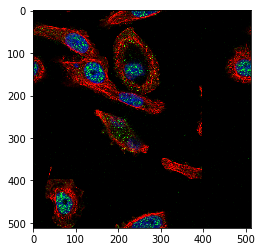

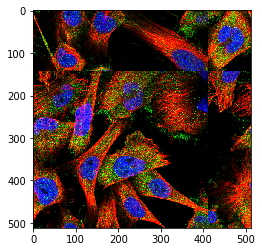

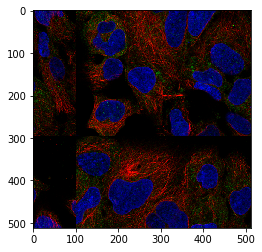

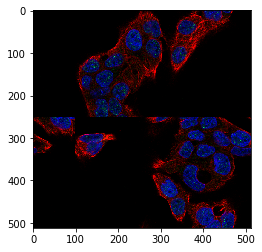

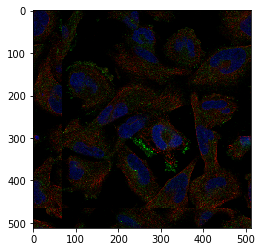

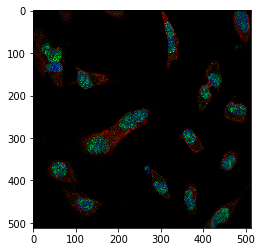

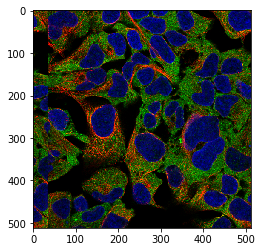

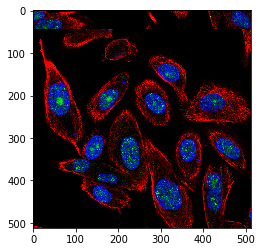

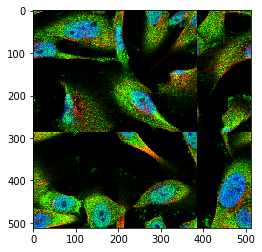

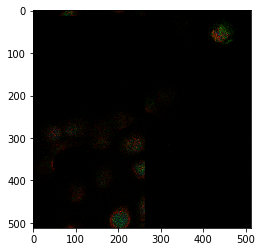

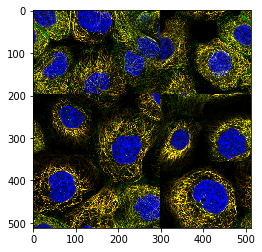

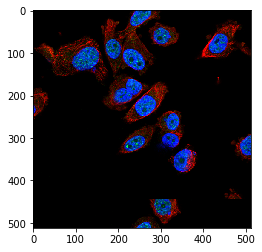

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [118]:
best_score = 0
model = ProteinClassifier(lr=1e-3)
model_helper = TrainingHelper(step_size=5, 
                y_value_names=["training loss", "training F1 score"])
itr = mini_dataset.make_one_shot_iterator()
try:
    for step, x in enumerate(itr):
        with tf.device("/device:GPU:0"):
            loss = model.optimize(x['train/image'].numpy(), x['train/label'],training=True, dropout=True, augment=True, blur=False)
            score = model.test(x['train/image'], x['train/label'])
            
            model_helper.append_outputs_if_required({"training loss" : loss, "training F1 score" : score},
                                                    curr_step=step, print_output=True)

except Exception as err:
    raise
finally:
    pass

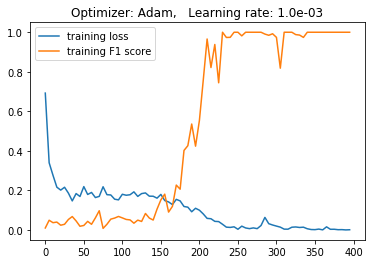

In [28]:
model_helper.show_graph(title="Optimizer: %s,   Learning rate: %.1e" % ("Adam", 1e-3),
                     keys_to_print=["training loss", "training F1 score"])

[20.11|05:09:06] Step 0: training loss: 0.778321
[20.11|05:09:06] Step 0: training F1 score: 0.167784
[20.11|05:09:55] Step 50: training loss: 0.780404
[20.11|05:09:55] Step 50: training F1 score: 0.215959
[20.11|05:10:44] Step 100: training loss: 0.824344
[20.11|05:10:44] Step 100: training F1 score: 0.199327
[20.11|05:11:34] Step 150: training loss: 0.760680
[20.11|05:11:34] Step 150: training F1 score: 0.262094
[20.11|05:12:23] Step 200: training loss: 0.746239
[20.11|05:12:23] Step 200: training F1 score: 0.303156
[20.11|05:13:13] Step 250: training loss: 0.929548
[20.11|05:13:13] Step 250: training F1 score: 0.070387
[20.11|05:14:03] Step 300: training loss: 0.732986
[20.11|05:14:03] Step 300: training F1 score: 0.247754
[20.11|05:14:52] Step 350: training loss: 0.763764
[20.11|05:14:52] Step 350: training F1 score: 0.299200
[20.11|05:15:42] Step 400: training loss: 0.744735
[20.11|05:15:42] Step 400: training F1 score: 0.360464
[20.11|05:16:32] Step 450: training loss: 0.714931
[

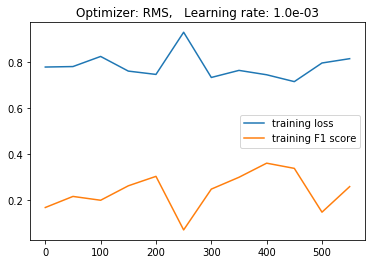

[20.11|05:19:02] Step 0: training loss: 0.784658
[20.11|05:19:02] Step 0: training F1 score: 0.121576
[20.11|05:19:51] Step 50: training loss: 0.799216
[20.11|05:19:51] Step 50: training F1 score: 0.100010
[20.11|05:20:41] Step 100: training loss: 0.826239
[20.11|05:20:41] Step 100: training F1 score: 0.124153
[20.11|05:21:30] Step 150: training loss: 0.794298
[20.11|05:21:30] Step 150: training F1 score: 0.224430
[20.11|05:22:20] Step 200: training loss: 0.762871
[20.11|05:22:20] Step 200: training F1 score: 0.285764
[20.11|05:23:10] Step 250: training loss: 0.761209
[20.11|05:23:10] Step 250: training F1 score: 0.364044
[20.11|05:24:00] Step 300: training loss: 0.666713
[20.11|05:24:00] Step 300: training F1 score: 0.514439
[20.11|05:24:49] Step 350: training loss: 0.535199
[20.11|05:24:49] Step 350: training F1 score: 0.578027
[20.11|05:25:38] Step 400: training loss: 0.482008
[20.11|05:25:38] Step 400: training F1 score: 0.556434
[20.11|05:26:27] Step 450: training loss: 0.389565
[

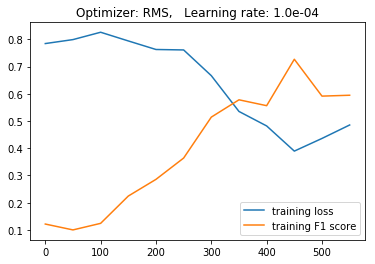

[20.11|05:28:56] Step 0: training loss: 0.770201
[20.11|05:28:56] Step 0: training F1 score: 0.127708
[20.11|05:29:45] Step 50: training loss: 0.791643
[20.11|05:29:45] Step 50: training F1 score: 0.053571
[20.11|05:30:34] Step 100: training loss: 0.788975
[20.11|05:30:34] Step 100: training F1 score: 0.083529
[20.11|05:31:24] Step 150: training loss: 0.813955
[20.11|05:31:24] Step 150: training F1 score: 0.167120
[20.11|05:32:13] Step 200: training loss: 0.810715
[20.11|05:32:13] Step 200: training F1 score: 0.206534
[20.11|05:33:03] Step 250: training loss: 0.768240
[20.11|05:33:03] Step 250: training F1 score: 0.254209
[20.11|05:33:52] Step 300: training loss: 0.821787
[20.11|05:33:52] Step 300: training F1 score: 0.251948
[20.11|05:34:41] Step 350: training loss: 0.754469
[20.11|05:34:41] Step 350: training F1 score: 0.233478
[20.11|05:35:30] Step 400: training loss: 0.762887
[20.11|05:35:30] Step 400: training F1 score: 0.241365
[20.11|05:36:19] Step 450: training loss: 0.741686
[

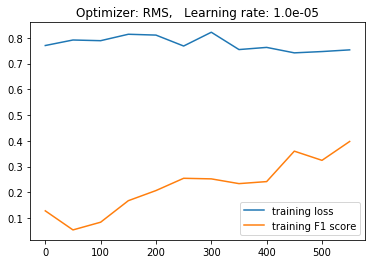

[20.11|05:38:49] Step 0: training loss: 0.832898
[20.11|05:38:49] Step 0: training F1 score: 0.187050
[20.11|05:39:38] Step 50: training loss: 0.763778
[20.11|05:39:38] Step 50: training F1 score: 0.178618
[20.11|05:40:27] Step 100: training loss: 0.785301
[20.11|05:40:27] Step 100: training F1 score: 0.230220
[20.11|05:41:17] Step 150: training loss: 0.806460
[20.11|05:41:17] Step 150: training F1 score: 0.164599


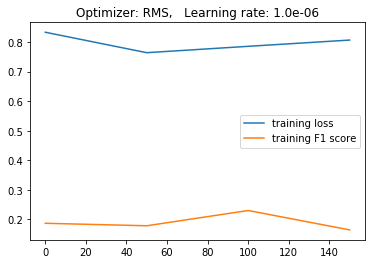

KeyboardInterrupt: 

In [69]:
best_score = 0
optimizers =['RMS']
lrs = [1e-3, 1e-4, 1e-5, 1e-6]
for optimizer in optimizers:
    for lr in lrs:
        model = ProteinClassifier(lr=lr, optimizer=optimizer)
        model_helper = TrainingHelper(step_size=50, 
                        y_value_names=["training loss", "training F1 score"])
        itr = mini_dataset.make_one_shot_iterator()
        try:
            for step, x in enumerate(itr):
                with tf.device("/device:GPU:0"):
                    loss = model.optimize(x['train/image'], x['train/label'], dropout=False, augment=False, loss_type='f1')
                    score = model.test(x['train/image'], x['train/label'])

                    model_helper.append_outputs_if_required({"training loss" : loss, "training F1 score" : score},
                                                            curr_step=step, print_output=True)
        

        except Exception as err:
            raise
        finally:
            model_helper.show_graph(title="Optimizer: %s,   Learning rate: %.1e" % (optimizer, lr),
             keys_to_print=["training loss", "training F1 score"])

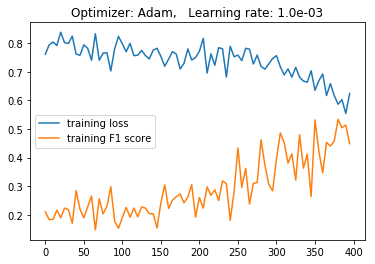

In [57]:
model_helper.show_graph(title="Optimizer: %s,   Learning rate: %.1e" % ("Adam", 1e-3),
                     keys_to_print=["training loss", "training F1 score"])

In [10]:
best_score = 0.48

model = ProteinClassifier(lr=1e-4)
model_helper = TrainingHelper(step_size=50, 
                y_value_names=["training loss", "training F1 score", "validation score"])
model.load_weights('cpt/cpt_w_noise.weights')
itr = train_dataset.make_one_shot_iterator()

try:
    for step, x in enumerate(itr):
        with tf.device("/device:GPU:0"):

            loss = model.optimize(x['train/image'].numpy(), x['train/label'],training=True, dropout=True, augment=True, blur=False)
            model_helper.append_outputs_if_required({"training loss" : loss},
                                                            curr_step=step, print_output=False)
            if (step % 500 == 0):
                predictions = None
                labels = None
                val_itr = val_dataset.make_one_shot_iterator()
                for step_val, x_val in enumerate(val_itr):
                    curr_prediction = model.predict_protein(x_val['validation/image'])
                    if predictions is not None:
                        predictions = np.concatenate((predictions, curr_prediction), axis=0)
                        labels = np.concatenate((labels, x_val['validation/label'].numpy()))
                    else:
                        predictions = curr_prediction
                        labels = x_val['validation/label'].numpy()
                val_score = model.calc_f1_scores(labels, predictions)
                train_score = model.test(x['train/image'], x['train/label'])
                model_helper.append_outputs_if_required({"training loss" : loss, "training F1 score" : train_score,
                                                         "validation score" : val_score}, curr_step=step, print_output=True)
        if (step % 50 == 0):
            if (val_score > best_score):
                best_score = val_score
                model.save_weights('cpt/cpt_w_noise.weights')

except Exception as err:
    raise
finally:
    pass

[27.11|10:35:11] Step 0: training loss: 0.042806
[27.11|10:35:11] Step 0: training F1 score: 0.832381
[27.11|10:35:11] Step 0: validation score: 0.482699
[27.11|10:49:23] Step 500: training loss: 0.089070
[27.11|10:49:23] Step 500: training F1 score: 0.654167
[27.11|10:49:23] Step 500: validation score: 0.456717
[27.11|11:00:57] Step 1000: training loss: 0.050320
[27.11|11:00:57] Step 1000: training F1 score: 0.923809
[27.11|11:00:57] Step 1000: validation score: 0.450941
[27.11|11:12:42] Step 1500: training loss: 0.069482
[27.11|11:12:42] Step 1500: training F1 score: 0.805916
[27.11|11:12:42] Step 1500: validation score: 0.459626
[27.11|18:17:55] Step 20000: training loss: 0.058231
[27.11|18:17:55] Step 20000: training F1 score: 0.722222
[27.11|18:17:55] Step 20000: validation score: 0.462682
[27.11|18:29:10] Step 20500: training loss: 0.062729
[27.11|18:29:10] Step 20500: training F1 score: 0.844444
[27.11|18:29:10] Step 20500: validation score: 0.475273
[27.11|18:40:22] Step 21000:

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [11]:
best_score

<tf.Tensor: id=4442880, shape=(), dtype=float32, numpy=0.49402577>

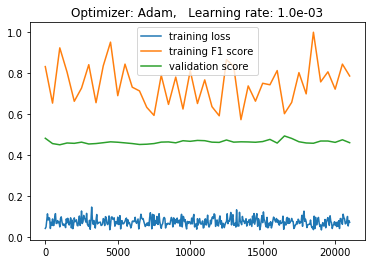

In [12]:
model_helper.show_graph(title="Optimizer: %s,   Learning rate: %.1e" % ("Adam", 1e-3),
                     keys_to_print=["training loss", "training F1 score", "validation score"])

## Graph for training with augmentation

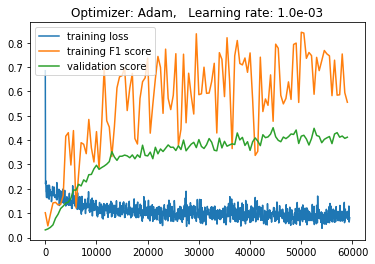

In [34]:
model_helper.show_graph(title="Optimizer: %s,   Learning rate: %.1e" % ("Adam", 1e-3),
                     keys_to_print=["training loss", "training F1 score", "validation score"])

In [13]:
predictions = None
labels = None
test_model = ProteinClassifier()
test_model.load_weights('cpt/cpt_w_noise.weights')
with tf.device("/device:GPU:0"):
    predictions = None
    labels = None
    val_itr = val_dataset.make_one_shot_iterator()
    for step_val, x_val in enumerate(val_itr):
        logits = test_model.get_logits(x_val['validation/image'])
        curr_prediction = test_model.get_normalized_logits(logits).numpy()
        if predictions is not None:
            predictions = np.concatenate((predictions, curr_prediction), axis=0)
            labels = np.concatenate((labels, x_val['validation/label'].numpy()))
        else:
            predictions = curr_prediction
            labels = x_val['validation/label'].numpy()

    

In [14]:
print(test_model.get_best_thresh(predictions, labels, save_threshold=False, step_size=0.005))

(0.265, <tf.Tensor: id=1402966, shape=(), dtype=float32, numpy=0.4478007>)


In [18]:
test_model = ProteinClassifier()
test_model.load_weights('cpt/cpt_w_noise.weights')
test_model.threshold = 0.2
protein_prediction = None
i = 0
with tf.device("/device:GPU:0"):
    val_itr = submission_dataset.make_one_shot_iterator()
    for val_step, val_x in enumerate(val_itr):
        i+=1
        if (i%100) == 0 :
            print("reached: {}".format(i))
        curr_prediction = test_model.predict_protein(val_x['test/image'])
        if protein_prediction is not None:
            protein_prediction = np.concatenate((protein_prediction, curr_prediction), axis=0)
        else:
            protein_prediction = curr_prediction
    
submission = pd.read_csv("sample_submission.csv")
submission_copy = submission.copy()
for i in range(11702):
    proteins = np.where(np.array(protein_prediction[i]) == 1)[0].tolist()
    guess = " ".join(str(x) for x in proteins[::-1])
    submission_copy['Predicted'][i] = guess

submission_copy.to_csv("submission_1.csv", index=False)

reached: 100
reached: 200
reached: 300
reached: 400
reached: 500
reached: 600
reached: 700


/home/michaelfi/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [19]:
submission_copy.head

<bound method NDFrame.head of                                          Id    Predicted
0      00008af0-bad0-11e8-b2b8-ac1f6b6435d0            2
1      0000a892-bacf-11e8-b2b8-ac1f6b6435d0       25 1 0
2      0006faa6-bac7-11e8-b2b7-ac1f6b6435d0      25 21 0
3      0008baca-bad7-11e8-b2b9-ac1f6b6435d0   25 17 16 0
4      000cce7e-bad4-11e8-b2b8-ac1f6b6435d0         25 0
5      00109f6a-bac8-11e8-b2b7-ac1f6b6435d0            4
6      001765de-bacd-11e8-b2b8-ac1f6b6435d0  25 21 5 4 0
7      0018641a-bac9-11e8-b2b8-ac1f6b6435d0         25 0
8      00200f22-bad7-11e8-b2b9-ac1f6b6435d0            0
9      0026f154-bac6-11e8-b2b7-ac1f6b6435d0        25 21
10     002729d2-bace-11e8-b2b8-ac1f6b6435d0         25 0
11     002c1a7c-bad4-11e8-b2b8-ac1f6b6435d0            5
12     003170fa-bacd-11e8-b2b8-ac1f6b6435d0       25 2 0
13     0031820a-baca-11e8-b2b8-ac1f6b6435d0            7
14     00407c16-bad3-11e8-b2b8-ac1f6b6435d0         25 0
15     005ce2ea-bacc-11e8-b2b8-ac1f6b6435d0    25 21 4 2
1